In [1]:
from scipy.interpolate import interp1d
from spec_id import Stack_posteriors, Get_flux, Mean_stack, Median_stack
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
from glob import glob
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})

# Robust Statistics

In [2]:
raw_spec = glob('/Volumes/Vince_research/Extractions/Quiescent_galaxies/n34694/*1D*')

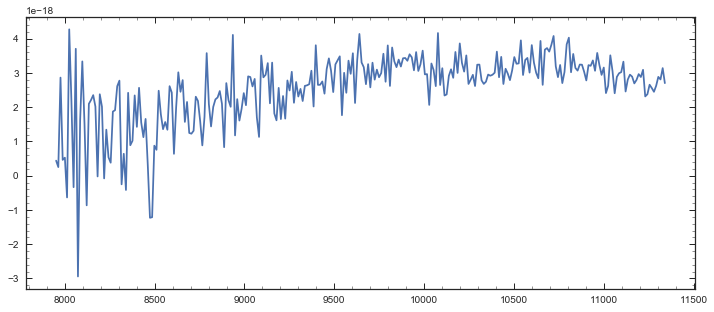

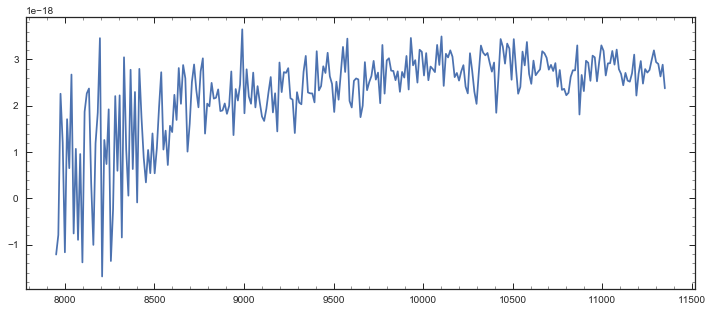

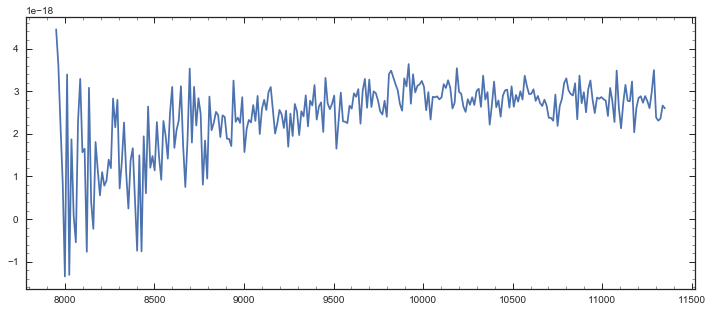

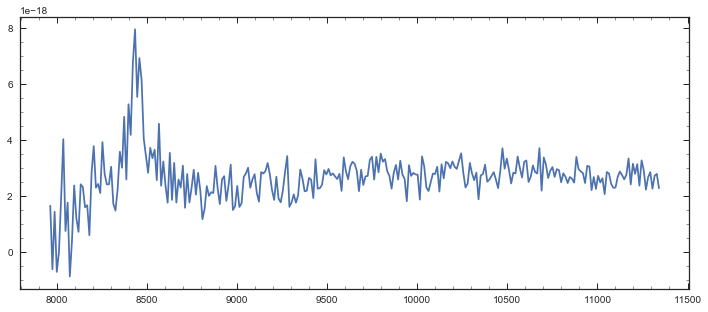

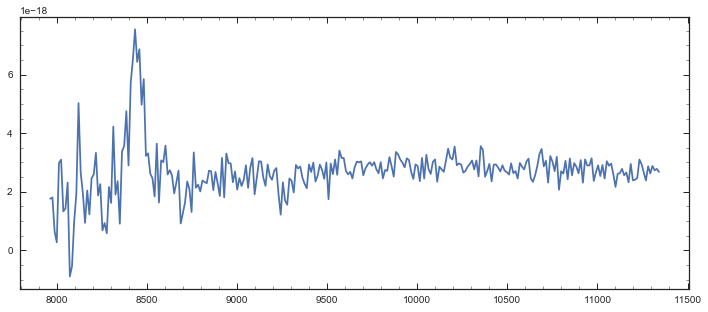

In [3]:
%matplotlib inline

for i in raw_spec[0:-1]:
    wv,fl,er = Get_flux(i)
    IDX = np.array([U for U in range(len(wv)) if 7800 < wv[U] < 11700]).astype(int)
    
    plt.figure(figsize=[12,5])
    plt.plot(wv[IDX],fl[IDX])
    plt.show()
    plt.close()

In [25]:
mn_wv,mn_fl,mn_er = Mean_stack(raw_spec[0:-1])
med_wv,med_fl,med_err = Median_stack(raw_spec[0:-1])
wv,fl,er =np.load('../spec_stacks_june14/n34694_stack.npy')
IDX = np.array([U for U in range(len(wv)) if 8000 < wv[U] < 11500]).astype(int)

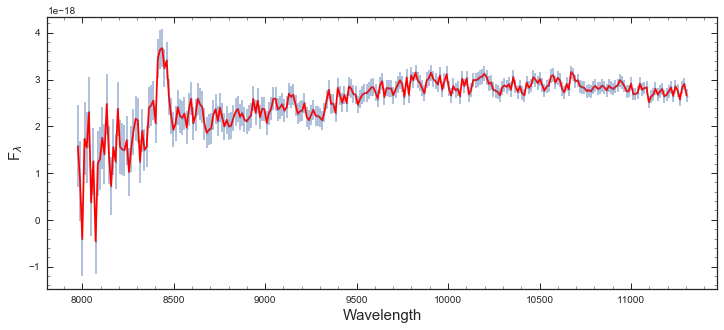

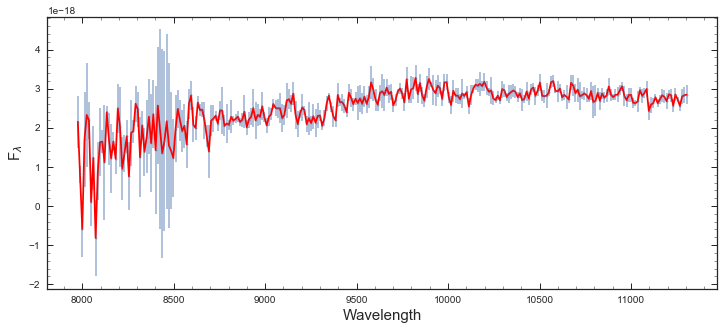

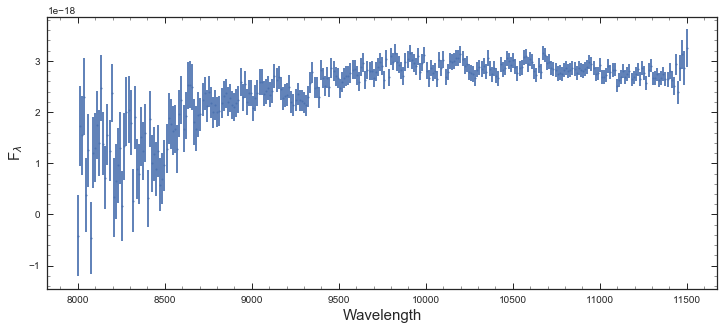

In [32]:
plt.figure(figsize=[12,5])
plt.plot(mn_wv,mn_fl,'r')
plt.errorbar(mn_wv,mn_fl,mn_er,fmt='o',ms=2,alpha = .5)
plt.xlabel('Wavelength',fontsize = 15)
plt.ylabel('F$_\lambda$',fontsize = 15)
plt.show()
plt.close()

plt.figure(figsize=[12,5])
plt.plot(med_wv,med_fl,'r')
plt.errorbar(med_wv,med_fl,med_err,fmt='o',ms=2,alpha = .5)
plt.xlabel('Wavelength',fontsize = 15)
plt.ylabel('F$_\lambda$',fontsize = 15)
plt.show()
plt.close()

plt.figure(figsize=[12,5])
plt.errorbar(wv[IDX],fl[IDX],er[IDX],fmt='o',ms=2)
plt.xlabel('Wavelength',fontsize = 15)
plt.ylabel('F$_\lambda$',fontsize = 15)
plt.show()
plt.close()

# Fitting a line

In [354]:
x = np.arange(10,12,.01)
y = .1*x - 1
data_x = np.random.choice(np.arange(10,12,.001),30)
error = np.random.normal(0,.1,30)
epsilon = np.random.normal(0,.1,30)
data_x = np.random.choice(np.arange(10,12,.001),30)
data_y = .1*data_x - 1 + epsilon 

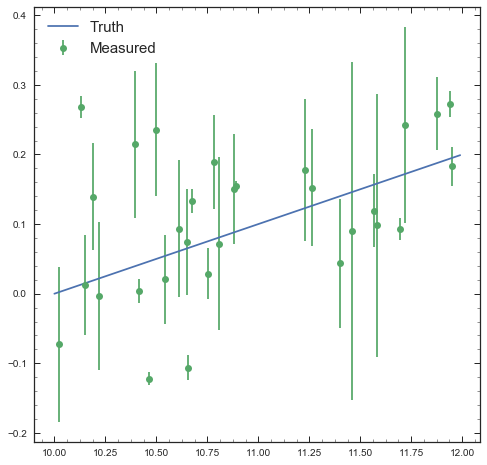

In [355]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot(x,y,label = 'Truth')
plt.errorbar(data_x,data_y,error,fmt='o',label='Measured')
plt.legend(loc=2,fontsize=15)

In [356]:
params,cov = np.polyfit(data_x,data_y,1,w=1/error**2,cov=True)
np_fit = np.polyval(params,x)
np_error = np.sqrt(cov[1][1] + cov[0][0]*x**2 + 2*x*cov[0][1])

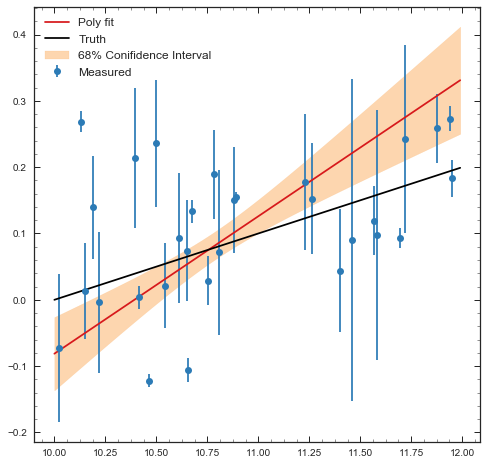

In [357]:
plt.figure(figsize=[8,8])
plt.errorbar(data_x,data_y,error,fmt='o',color='#2c7bb6',label='Measured')
plt.plot(x,np_fit,color='#d7191c',label = 'Poly fit')
plt.fill_between(x,np_fit - np_error,np_fit + np_error,color='#fdae61',alpha = .5,label = '68% Conifidence Interval')
plt.plot(x,y,'k',label = 'Truth')
plt.legend(loc=2,fontsize=12)

In [358]:
def Linear_fit(x,Y,sig,new_x):
    A=np.array([np.ones(len(x)),x]).T
    C =np.diag(sig**2)
    iC=inv(C)
    b,m = np.dot(inv(np.dot(np.dot(A.T,iC),A)),np.dot(np.dot(A.T,iC),Y))
    cov = inv(np.dot(np.dot(A.T,iC),A))
    var_b = cov[0][0]
    var_m = cov[1][1]
    sig_mb = cov[0][1]
    sig_y = np.sqrt(var_b + new_x**2*var_m + 2*new_x*sig_mb)
    return m*new_x+b , sig_y

In [359]:
l_fit,e_fit = Linear_fit(data_x,data_y,error,x)

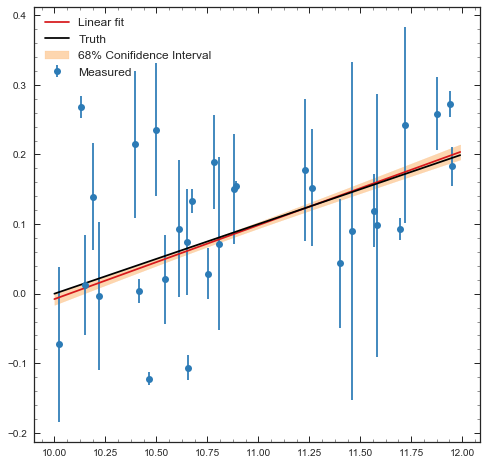

In [360]:
plt.figure(figsize=[8,8])
plt.errorbar(data_x,data_y,error,fmt='o',color='#2c7bb6',label='Measured')
plt.plot(x,l_fit,color='#d7191c',label = 'Linear fit')
plt.fill_between(x,l_fit - e_fit,l_fit + e_fit,color='#fdae61',alpha = .5,label = '68% Conifidence Interval')
plt.plot(x,y,'k',label = 'Truth')
plt.legend(loc=2,fontsize=12)

# Hierarchical Bayesian Statistics

In [365]:
def Gauss_dist(x, mu, sigma):
    G = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    C = np.trapz(G, x)
    G /= C
    return G

In [366]:
x=np.arange(0,6,0.01)
ers = np.arange(0,1,0.001)
gdist = Gauss_dist(x,3,.75)
sp_size = 12

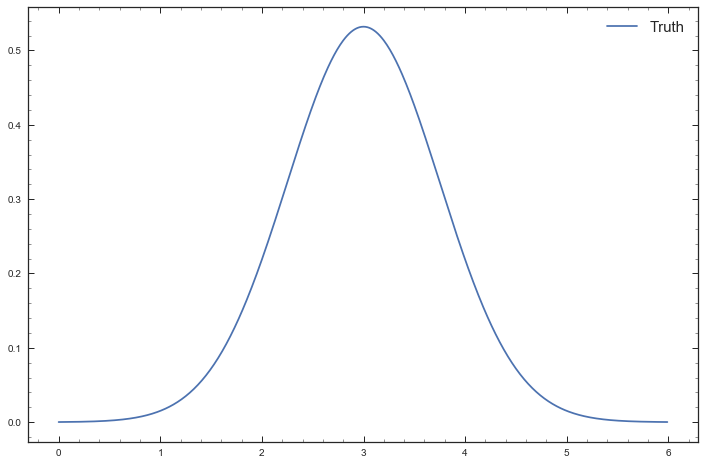

In [385]:
plt.figure(figsize=[12,8])
plt.plot(x,gdist,label='Truth')
plt.legend(fontsize=15)

In [374]:
dist_grid= np.zeros([sp_size,x.size])
for i in range(sp_size):
    dist_grid[i] = Gauss_dist(x,np.random.normal(3,.75),np.random.choice(ers))

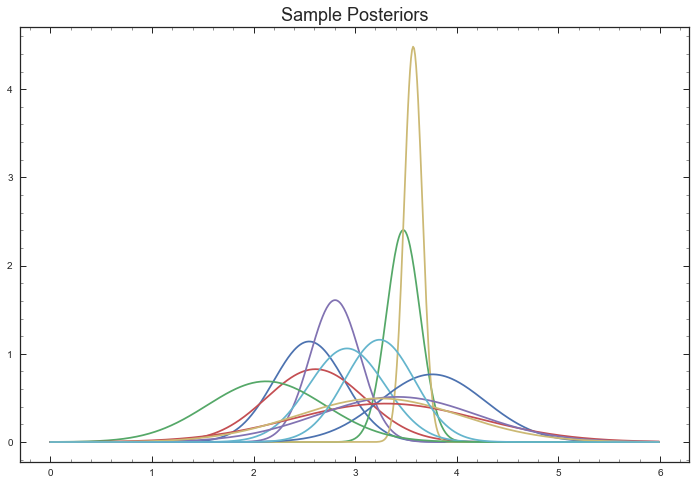

In [384]:
plt.figure(figsize=[12,8])
for i in range(sp_size):
    plt.plot(x,dist_grid[i])
plt.title('Sample Posteriors', fontsize =18)

In [376]:
Pos = Stack_posteriors(dist_grid,x)

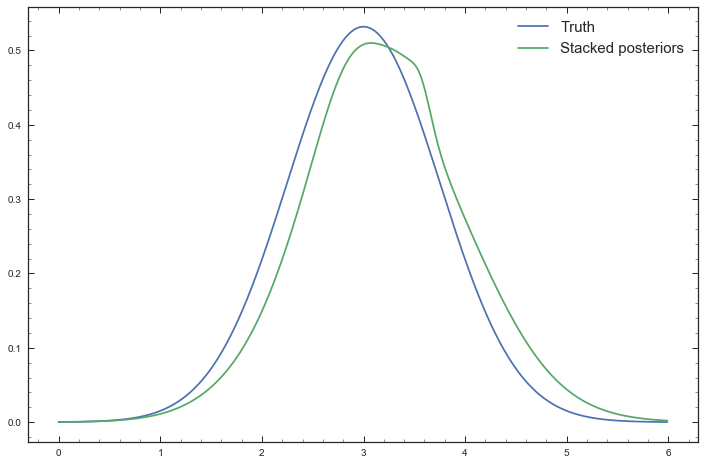

In [382]:
plt.figure(figsize=[12,8])
plt.plot(x,gdist,label = 'Truth')
plt.plot(x,Pos,label = 'Stacked posteriors')
plt.legend(fontsize = 15)